In [140]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class Config():
    vocab_size = 128
    example_number = 20000
    batch_size = 64
    buffer_size = 1000
    embedding_dim = 256
    rnn_size = 128
config = Config()

## Get Vocab

In [176]:
data_url = 'https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt'

pd_data = pd.read_csv(data_url)
selfies_list = list(map(sf.encoder, pd_data.iloc[:config.example_number, 0]))
all_selfies_symbols = sf.get_alphabet_from_selfies(selfies_list)
all_selfies_symbols.add('[nop]')
vocab_stoi = {o:i for o,i in zip(all_selfies_symbols, range(len(all_selfies_symbols)))}

In [177]:
config.pad_length = max([len(s) for s in selfies_list])
print(config.pad_length)

397


## Build data

In [142]:
# now get sequences
seqs = tokenizer.texts_to_sequences(selfies_list)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

# Now build dataset
seqs_data = tf.data.Dataset.from_tensor_slices((padded_seqs,))

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

data = seqs_data.map(split_input_target)
data = data.shuffle(config.buffer_size).batch(config.batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
for d in data:
    print(type(d))
    print(d[0].shape, d[1].shape)
    example = d[0]
    break

<class 'tuple'>
(64, 396) (64, 396)


## Build Model

In [148]:
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
h,s = tf.keras.layers.GRU(config.rnn_size, return_sequences=True, return_state=True)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
model = tf.keras.Model(inputs=x, outputs=(yhat, s))

# make model for inference
si = tf.keras.Input(shape=(config.rnn_size,))
xi = tf.keras.Input(shape=(None,))
x = xi
for layer in model.layers[1:]:
    if layer.name.startswith('gru'):
        x,s = layer(x, initial_state=si)
    else:
        x = layer(x)
#probs = tf.keras.layers.Activation('softmax')(x)
model_continue = tf.keras.Model(inputs=(xi, si), outputs=(x,s))

## Try Model

In [149]:
yhat, s = model(example)

In [150]:
model.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_34 (Embedding)     (None, None, 256)         32768     
_________________________________________________________________
gru_29 (GRU)                 [(None, None, 128), (None 148224    
_________________________________________________________________
dense_34 (Dense)             (None, None, 128)         16512     
Total params: 197,504
Trainable params: 197,504
Non-trainable params: 0
_________________________________________________________________


In [151]:
x, s = model_continue([example, s])
model_continue([x[...,0], s])
model_continue.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, None, 256)    32768       input_62[0][0]                   
__________________________________________________________________________________________________
input_61 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
gru_29 (GRU)                    [(None, None, 128),  148224      embedding_34[1][0]               
                                                                 input_61[0][0]            

## Train

In [152]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(tf.optimizers.Adam(1e-2), loss=[loss, None])
result = model.fit(data, epochs=3)

Epoch 1/3
312/312 [==============================] - 114s 358ms/step - loss: 0.2441 - dense_34_loss: 0.2441
Epoch 2/3
312/312 [==============================] - 111s 355ms/step - loss: 0.1582 - dense_34_loss: 0.1582
Epoch 3/3
312/312 [==============================] - 117s 376ms/step - loss: 0.1401 - dense_34_loss: 0.1401


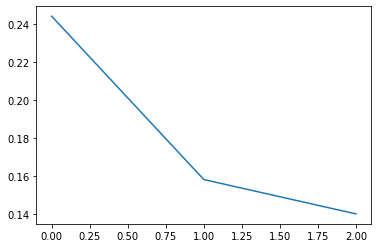

In [153]:
plt.plot(result.history['loss'])
plt.show()
model.reset_states()

## Try Trained Model

In [154]:
start = np.zeros((1, 10))
start[0, 0] = 1
start[0,1] = 2
x,s = model_continue([start, np.zeros((1, config.rnn_size))])

In [155]:
model_continue.layers[2].return_sequences=False

## Prune Model

## Save Model

In [156]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model_continue, '../model')

In [160]:
import json

tokenizer.get_config()

{'num_words': 128,
 'filters': '',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': None,
 'document_count': 20000,
 'word_counts': '{"[": 750277, "c": 529500, "]": 750277, "@": 26469, "h": 152309, "e": 29903, "x": 29903, "p": 32576, "l": 33408, "b": 130435, "r": 216136, "a": 129436, "n": 278264, "2": 93655, "_": 129436, "1": 238037, "i": 85784, "g": 85701, "=": 132976, "#": 3997, "o": 50466, "s": 11296, "3": 14868, "-": 2078, "+": 6008, "/": 2218, "f": 6432, "\\\\": 484}',
 'word_docs': '{"]": 20000, "e": 15112, "i": 19937, "x": 15112, "l": 16106, "_": 20000, "c": 20000, "p": 15747, "=": 19743, "@": 11531, "a": 20000, "[": 20000, "b": 20000, "h": 20000, "n": 20000, "2": 19547, "g": 19937, "1": 20000, "r": 20000, "o": 18842, "#": 3565, "3": 11284, "s": 8861, "-": 1963, "+": 5521, "/": 1306, "f": 3741, "\\\\": 470}',
 'index_docs': '{"2": 20000, "18": 15112, "13": 19937, "19": 15112, "16": 16106, "11": 20000, "3": 20000, "17": 15747, "8": 19743, "20": 11531, "10": 20000